# Local Binary Pattern을 활용한 Face Recognition
---
해당 파일을 작성하여 12월 13일 자정까지 제출하시오.
제출할 때 ***학번.ipynb*** 파일로 저장하여 제출하기기 바랍니다.
### Dataset Description:
- 그레이 스케일 face 이미지 17장 + Non-face 이미지 1장 총 18장으로 구성
- 각 이미지의 사이즈는 195 × 231

- apple1_gray.jpg, 
  subject01.centerlight.jpg, subject01.happy.jpg, subject01.normal.jpg,
  subject02.normal.jpg, subject03.normal.jpg, subject07.centerlight.jpg, subject07.happy.jpg, subject07.normal.jpg, subject10.normal.jpg, subject11.centerlight.jpg, subject11.happy.jpg, subject11.normal.jpg, subject12.normal.jpg, subject14.happy.jpg, subject14.normal.jpg, subject14.sad.jpg, subject15.normal.jpg

### 데이터셋 준비
- https://docs.google.com/uc?export=download&id=1sWf596Yy4GkBxPA9VEiETPXPU3eYfs3H
- 위 주소로 압축 파일 다운로드 후 압축 해제

In [ ]:
# 압축 해제된 폴더의 전체 데이터 업로드 (전체 이미지 선택 후 일괄 업로드)
from google.colab import files

uploaded = files.upload()

Saving apple1_gray.jpg to apple1_gray.jpg
Saving subject01.centerlight.jpg to subject01.centerlight.jpg
Saving subject01.happy.jpg to subject01.happy.jpg
Saving subject01.normal.jpg to subject01.normal.jpg
Saving subject02.normal.jpg to subject02.normal.jpg
Saving subject03.normal.jpg to subject03.normal.jpg
Saving subject07.centerlight.jpg to subject07.centerlight.jpg
Saving subject07.happy.jpg to subject07.happy.jpg
Saving subject07.normal.jpg to subject07.normal.jpg
Saving subject10.normal.jpg to subject10.normal.jpg
Saving subject11.centerlight.jpg to subject11.centerlight.jpg
Saving subject11.happy.jpg to subject11.happy.jpg
Saving subject11.normal.jpg to subject11.normal.jpg
Saving subject12.normal.jpg to subject12.normal.jpg
Saving subject14.happy.jpg to subject14.happy.jpg
Saving subject14.normal.jpg to subject14.normal.jpg
Saving subject14.sad.jpg to subject14.sad.jpg
Saving subject15.normal.jpg to subject15.normal.jpg


In [ ]:
# 파이썬 라이브러리 import
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import cv2

In [ ]:
# 주어진 영상을 읽기
dataset_dir  = os.listdir('./LBP-dataset')
dataset_dir = [img for img in dataset_dir if img.endswith(".jpg")]
dataset_dir = sorted(dataset_dir)

width  = 195
height = 231

All Images:
All tensor shape :  (18, 231, 195)


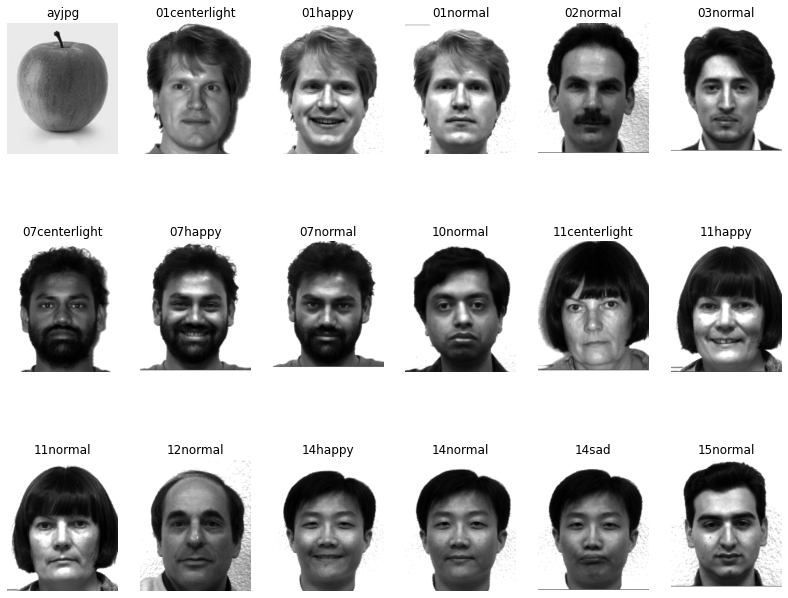

In [ ]:
# Dataset 이미지 불러오기
print('All Images:')
image_names = dataset_dir
tensor = np.ndarray(shape=(len(image_names), height, width), dtype=np.float64)
print('All tensor shape : ', tensor.shape)

plt.figure(figsize=(10, 8))
for i in range(len(image_names)):
    img = plt.imread('./LBP-dataset/' + image_names[i])
    tensor[i] = np.array(img, dtype='float64')
    plt.subplot(3, 6, 1+i)
    plt.title(image_names[i].split('.')[0][-2:]+image_names[i].split('.')[1])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off', top='off', right='off', left='off', which='both')
plt.show()

In [ ]:
# 입력 row, col 위치의 pixel과 center pixel을 비교해 크거나 같으면 1, 아니면 0 반환
# center pixel보다 밝으면 1, 어두우면 0으로 코딩하는 코드를 작성하시오. (상대적인 밝기 변화 측정)
def get_pixel(img, center, row, col):
    # 코드 작성
    new_value = 0

    try: 
      if img[row][col] >= center: new_value = 1
      else: new_value = 0
    except: pass
    
    return new_value

In [ ]:
'''
64      128     1
32      0       2
16      8       4
'''
# 위에서 작성한 get_pixel에서 얻은 상대적인 밝기에 대한 정보에 중앙을 제외하고
# 우측 상단부터 ''시계'' 방향으로 [1, 2, 4, 8, 16, 32, 64, 128]의 가중치를 적용. (위 3x3 matrix 참조)
# 입력 이미지의 모든 pixel에 3x3 영역을 이동시켜가며 상대적인 밝기 변화를 측정(get_pixel 함수)하고 위의 3x3 영역 가중치를 적용하는 코드를 작성하시오.
def lbp_calculated_pixel(img, row, col):
    
    # 코드 작성
    # 위에서 작성한  함수 get_pixel 활용
    center = img[row][col]
    value_array = []
    loc = [(row-1, col+1), (row, col+1), (row+1, col+1), (row+1, col), 
           (row+1, col-1), (row, col-1), (row-1, col-1), (row-1, col)]
    for i in range(len(loc)):
      value_array.append(get_pixel(img, center, loc[i][0], loc[i][1]))

    weight = [1, 2, 4, 8, 16, 32, 64, 128]
    value = 0
    for i in range(len(value_array)):
      value += value_array[i] * weight[i]

    return value

In [ ]:
# 위에서 구한 lbp_calculated_pixel함수에서 얻은 값을 [0~225]의 값을 갖도록 히스토그램을 구하기 위한 함수를 작성
def calcHistogram(lbp_img, height, width):
  h = [0.0] * 256
  for i in range(height):
    for j in range(width):
      h[lbp_img[i, j]] += 1
  return np.array(h) / (height * width)

In [ ]:
# LBP 이미지, 히스토그램 생성
lbp_img_list = []
lbp_hist_list = []

for n in range(len(image_names)):
    lbp_img = np.zeros((height, width), np.uint8)

    for i in range(0, height):
        for j in range(0, width):
          lbp_img[i, j] = lbp_calculated_pixel(tensor[n], i, j)
    lbp_hist = calcHistogram(lbp_img, height, width)
    # lbp_hist = cv2.calcHist([lbp_img], [0], None, [256], [0, 256])

    lbp_img_list.append(lbp_img)
    lbp_hist_list.append(lbp_hist)

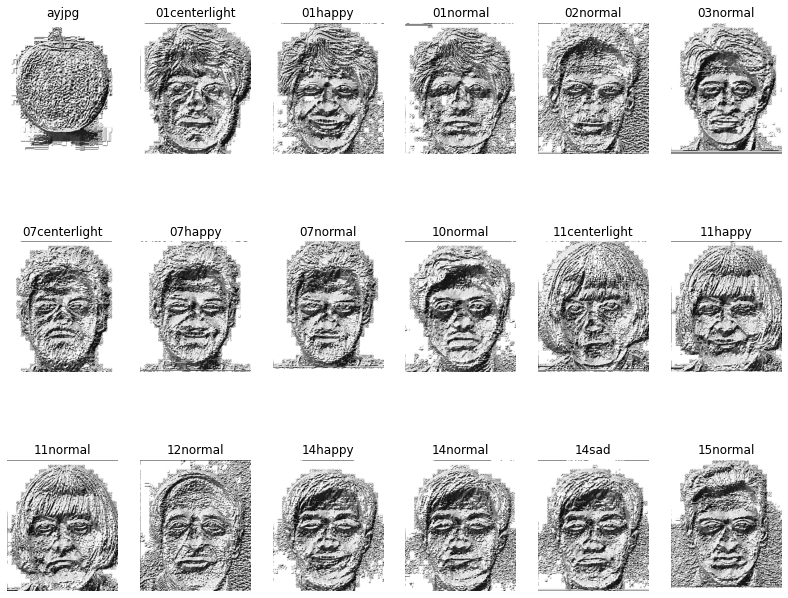

In [ ]:
# LBP 이미지 출력
plt.figure(figsize=(10, 8))
for i in range(len(lbp_img_list)):
    plt.subplot(3, 6, 1+i)
    plt.title(image_names[i].split('.')[0][-2:]+image_names[i].split('.')[1])
    plt.imshow(lbp_img_list[i], cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off', top='off', right='off', left='off', which='both')
plt.show()

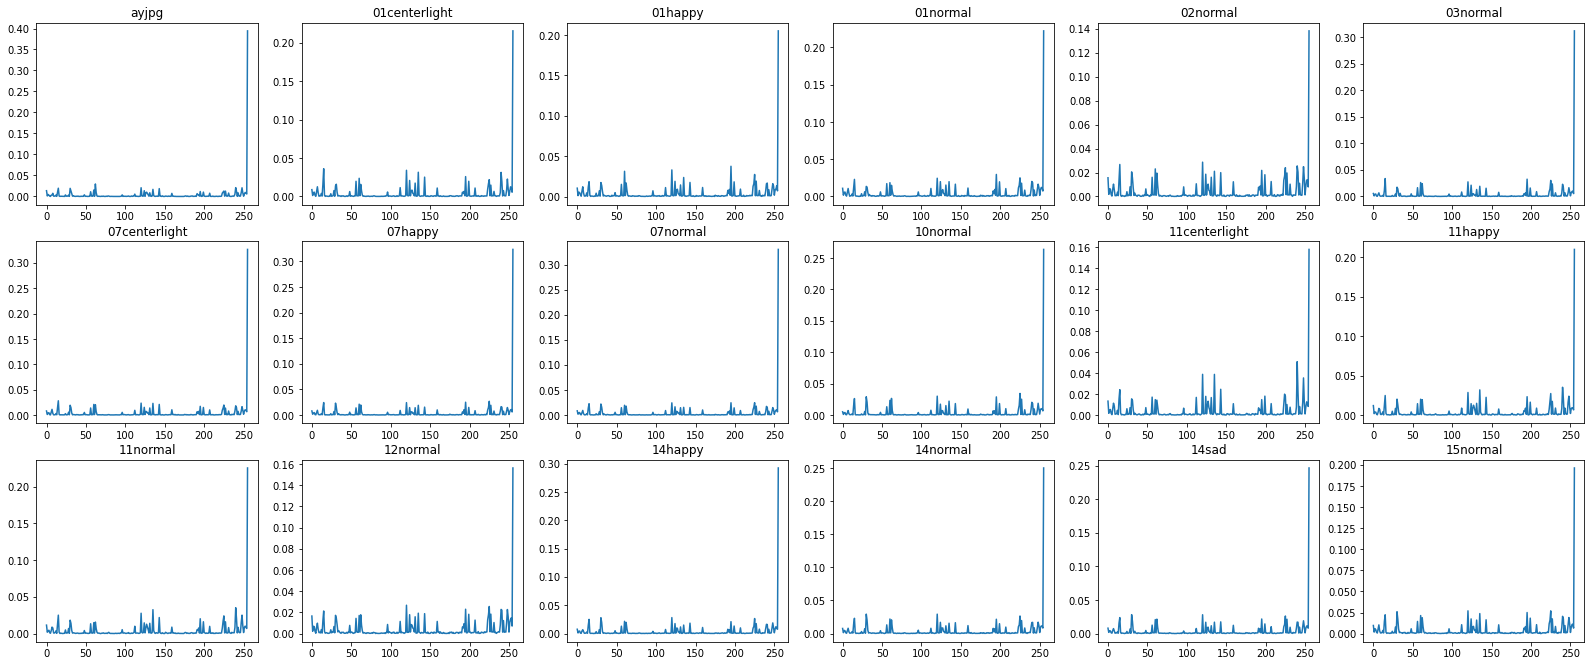

In [ ]:
# LBP 히스토그램 출력
plt.figure(figsize=(20, 8))
for i in range(len(lbp_hist_list)):
    plt.subplot(3, 6, 1+i)
    plt.title(image_names[i].split('.')[0][-2:]+image_names[i].split('.')[1])
    plt.plot(lbp_hist_list[i])
    plt.subplots_adjust(right=1.2, top=1.2)
plt.show()